# Load Packages

In [1]:
import kagglehub
from kaggle.api.kaggle_api_extended import KaggleApi
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Secrets

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

# Load Data

## Download From Kaggle

In [3]:
api = KaggleApi()
api.authenticate()

dataset = "himanshuwagh/spotify-million"
files = api.dataset_list_files(dataset).files
file_names = [file.name for file in files]

print(f"Total files in dataset: {len(file_names)}")
print(f"Note: This is a subset of the full Spotify Million Playlist Dataset")

for file_name in file_names:
    path = kagglehub.dataset_download(dataset, path=file_name)
    print(f"Downloaded {file_name}")

Total files in dataset: 20
Note: This is a subset of the full Spotify Million Playlist Dataset
Downloaded README.md
Downloaded data/mpd.slice.0-999.json
Downloaded data/mpd.slice.1000-1999.json
Downloaded data/mpd.slice.10000-10999.json
Downloaded data/mpd.slice.100000-100999.json
Downloaded data/mpd.slice.101000-101999.json
Downloaded data/mpd.slice.102000-102999.json
Downloaded data/mpd.slice.103000-103999.json
Downloaded data/mpd.slice.104000-104999.json
Downloaded data/mpd.slice.105000-105999.json
Downloaded data/mpd.slice.106000-106999.json
Downloaded data/mpd.slice.107000-107999.json
Downloaded data/mpd.slice.108000-108999.json
Downloaded data/mpd.slice.109000-109999.json
Downloaded data/mpd.slice.11000-11999.json
Downloaded data/mpd.slice.110000-110999.json
Downloaded data/mpd.slice.111000-111999.json
Downloaded data/mpd.slice.112000-112999.json
Downloaded data/mpd.slice.113000-113999.json
Downloaded data/mpd.slice.114000-114999.json


## Load Data Files

In [4]:
# Define data path
DATA_PATH = Path.home() / ".cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1/data"

# Get all downloaded slice files
slice_files = sorted(DATA_PATH.glob("mpd.slice.*.json"))
print(f"Found {len(slice_files)} slice files")

# Load all slices and combine playlists
all_playlists = []
for slice_file in slice_files:
    with open(slice_file) as f:
        data = json.load(f)
        all_playlists.extend(data["playlists"])

print(f"Total playlists loaded: {len(all_playlists)}")

# Convert to DataFrame
df = pd.json_normalize(all_playlists)
print(f"DataFrame shape: {df.shape}")
df.head()

Found 19 slice files
Total playlists loaded: 19000
DataFrame shape: (19000, 12)


,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Throwbacks,false,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,Awesome Playlist,false,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,false,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,false,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,false,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN


In [5]:
df.loc[1, 'tracks']

[{'pos': 0,
  'artist_name': 'Survivor',
  'track_uri': 'spotify:track:2HHtWyy5CgaQbC7XSoOb0e',
  'artist_uri': 'spotify:artist:26bcq2nyj5GB7uRr558iQg',
  'track_name': 'Eye of the Tiger',
  'album_uri': 'spotify:album:4PT9VulQaQP6XR1xBI2x1W',
  'duration_ms': 243773,
  'album_name': 'Eye Of The Tiger'},
 {'pos': 1,
  'artist_name': 'Daniel Tidwell',
  'track_uri': 'spotify:track:1MYYt7h6amcrauCOoso3Gx',
  'artist_uri': 'spotify:artist:7zdmbPudNX4SQJXnYIuCTC',
  'track_name': 'Libera Me From Hell (Tengen Toppa Gurren Lagann)',
  'album_uri': 'spotify:album:3q8vR3PFV8kG1m1Iv8DpKq',
  'duration_ms': 70294,
  'album_name': 'Versus Hollywood'},
 {'pos': 2,
  'artist_name': 'Daniel Tidwell',
  'track_uri': 'spotify:track:3x2mJ2bjCIU70NrH49CtYR',
  'artist_uri': 'spotify:artist:7zdmbPudNX4SQJXnYIuCTC',
  'track_name': 'Pokémon Theme',
  'album_uri': 'spotify:album:3q8vR3PFV8kG1m1Iv8DpKq',
  'duration_ms': 65306,
  'album_name': 'Versus Hollywood'},
 {'pos': 3,
  'artist_name': 'Daniel Tidwel

In [6]:
# Explode the tracks column
tracks_df = df.explode('tracks').reset_index(drop=True)

# Normalize the track dictionaries into separate columns
track_features = pd.json_normalize(tracks_df['tracks'])
tracks_df = pd.concat([
    tracks_df.drop('tracks', axis=1),
    track_features
], axis=1)

# Ensure unique column names (duplicate labels can break groupby/agg)
cols = pd.Series(tracks_df.columns)
if cols.duplicated().any():
    for col in cols[cols.duplicated()].unique():
        idxs = np.where(cols == col)[0]
        for j, idx in enumerate(idxs):
            if j == 0:
                continue
            cols.iloc[idx] = f"{col}__{j+1}"
    tracks_df.columns = cols

# Ensure expected numeric types
if 'duration_ms' in tracks_df.columns:
    tracks_df['duration_ms'] = pd.to_numeric(tracks_df['duration_ms'], errors='coerce')
if 'pos' in tracks_df.columns:
    tracks_df['pos'] = pd.to_numeric(tracks_df['pos'], errors='coerce')

print(tracks_df.shape)
print(f"Duplicate column labels: {tracks_df.columns.duplicated().sum()}")
tracks_df.head()

(1273021, 19)
Duplicate column labels: 0


,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms__2,album_name
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
1,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
2,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
3,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
4,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,NaN,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


# Data Exploration


## Basic Structure


In [7]:
print(f"Total tracks: {len(tracks_df):,}")
print(f"Total playlists: {tracks_df['pid'].nunique():,}")
print(f"Columns: {tracks_df.shape[1]}")
print(f"\nColumn types:")
print(tracks_df.dtypes)


Total tracks: 1,273,021
Total playlists: 19,000
Columns: 19

Column types:
name              object
collaborative     object
pid                int64
modified_at        int64
num_tracks         int64
num_albums         int64
num_followers      int64
num_edits          int64
duration_ms        int64
num_artists        int64
description       object
pos                int64
artist_name       object
track_uri         object
artist_uri        object
track_name        object
album_uri         object
duration_ms__2     int64
album_name        object
dtype: object


In [8]:
tracks_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273021 entries, 0 to 1273020
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   name            1273021 non-null  object
 1   collaborative   1273021 non-null  object
 2   pid             1273021 non-null  int64 
 3   modified_at     1273021 non-null  int64 
 4   num_tracks      1273021 non-null  int64 
 5   num_albums      1273021 non-null  int64 
 6   num_followers   1273021 non-null  int64 
 7   num_edits       1273021 non-null  int64 
 8   duration_ms     1273021 non-null  int64 
 9   num_artists     1273021 non-null  int64 
 10  description     25367 non-null    object
 11  pos             1273021 non-null  int64 
 12  artist_name     1273021 non-null  object
 13  track_uri       1273021 non-null  object
 14  artist_uri      1273021 non-null  object
 15  track_name      1273021 non-null  object
 16  album_uri       1273021 non-null  object
 17  duration

In [9]:
missing = tracks_df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


description    1247654
dtype: int64

## Track-Level Statistics


In [10]:
print(f"Unique tracks: {tracks_df['track_uri'].nunique():,}")
print(f"Unique artists: {tracks_df['artist_uri'].nunique():,}")
print(f"Unique albums: {tracks_df['album_uri'].nunique():,}")
print(f"Unique track names: {tracks_df['track_name'].nunique():,}")


Unique tracks: 252,999
Unique artists: 49,124
Unique albums: 115,697
Unique track names: 191,797


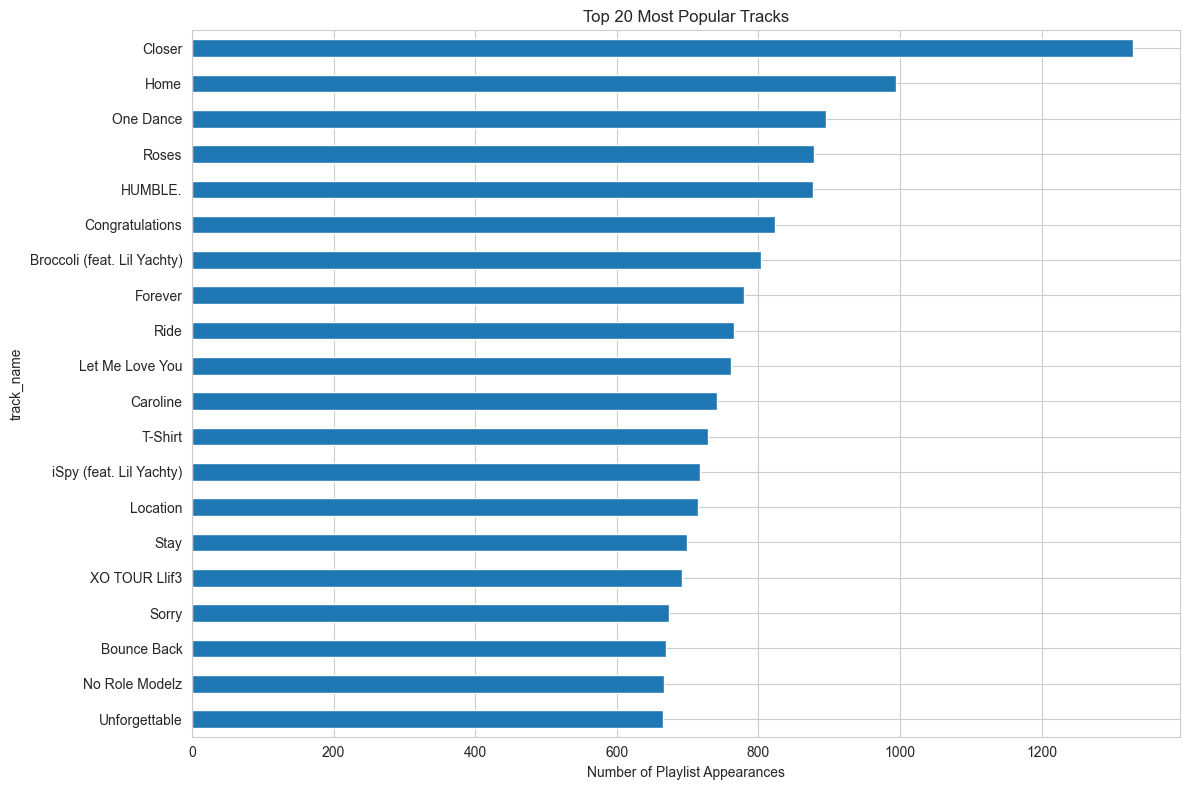

In [11]:
top_tracks = tracks_df['track_name'].value_counts().head(20)
plt.figure(figsize=(12, 8))
top_tracks.plot(kind='barh')
plt.xlabel('Number of Playlist Appearances')
plt.title('Top 20 Most Popular Tracks')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


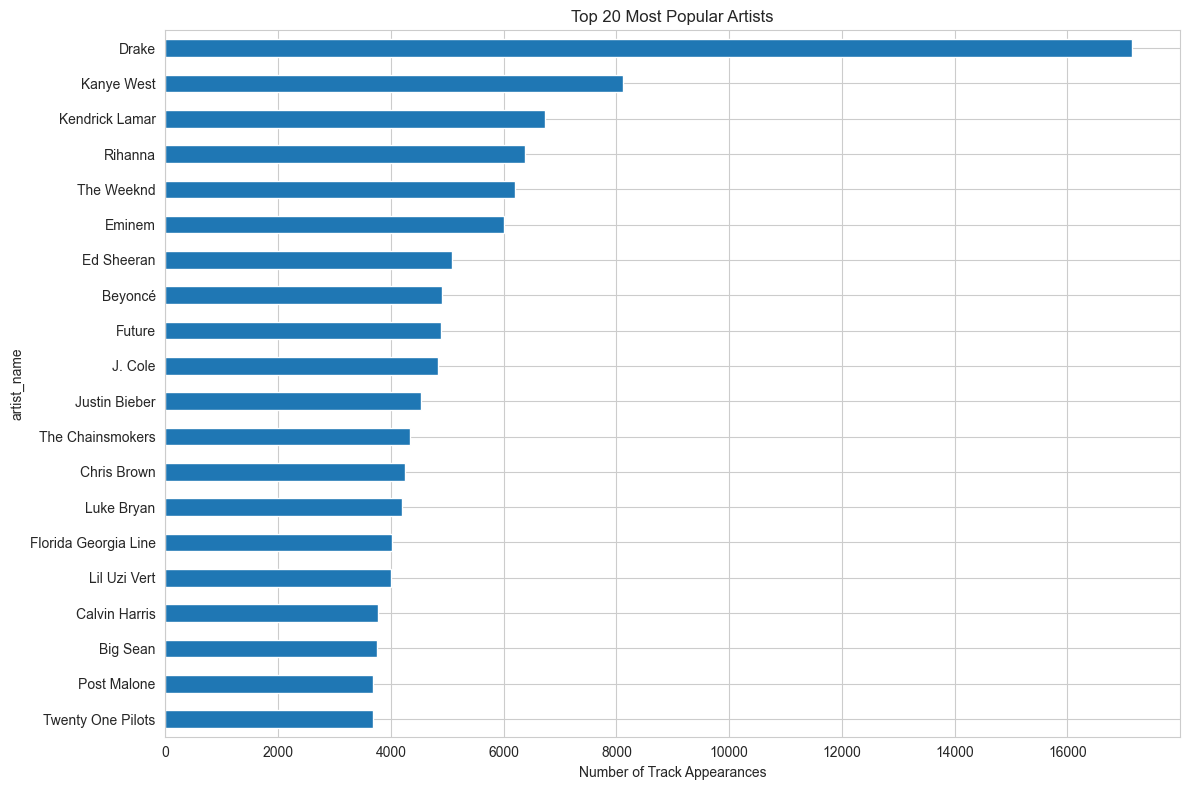

In [12]:
top_artists = tracks_df['artist_name'].value_counts().head(20)
plt.figure(figsize=(12, 8))
top_artists.plot(kind='barh')
plt.xlabel('Number of Track Appearances')
plt.title('Top 20 Most Popular Artists')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Playlist-Level Statistics


In [13]:
playlist_stats = tracks_df.groupby('pid').agg(
    num_tracks=('track_uri', 'count'),
    num_unique_artists=('artist_uri', 'nunique'),
    num_unique_albums=('album_uri', 'nunique'),
    total_duration_ms=('duration_ms', 'sum')
)

playlist_stats['total_duration_hours'] = playlist_stats['total_duration_ms'] / (1000 * 60 * 60)
playlist_stats.describe()


,num_tracks,num_unique_artists,num_unique_albums,total_duration_ms,total_duration_hours
count,19000.000000,19000.000000,19000.000000,1.900000e+04,19000.000000
mean,67.001105,38.047474,49.830000,1.740281e+09,483.411313
std,54.332210,30.137692,40.049114,2.722437e+09,756.232436
min,5.000000,3.000000,2.000000,3.889872e+06,1.080520
25%,26.000000,16.000000,20.000000,1.558223e+08,43.283977
50%,49.000000,30.000000,38.000000,5.650624e+08,156.961781
75%,93.000000,51.000000,68.000000,2.016220e+09,560.061055
max,250.000000,213.000000,237.000000,2.032088e+10,5644.690208


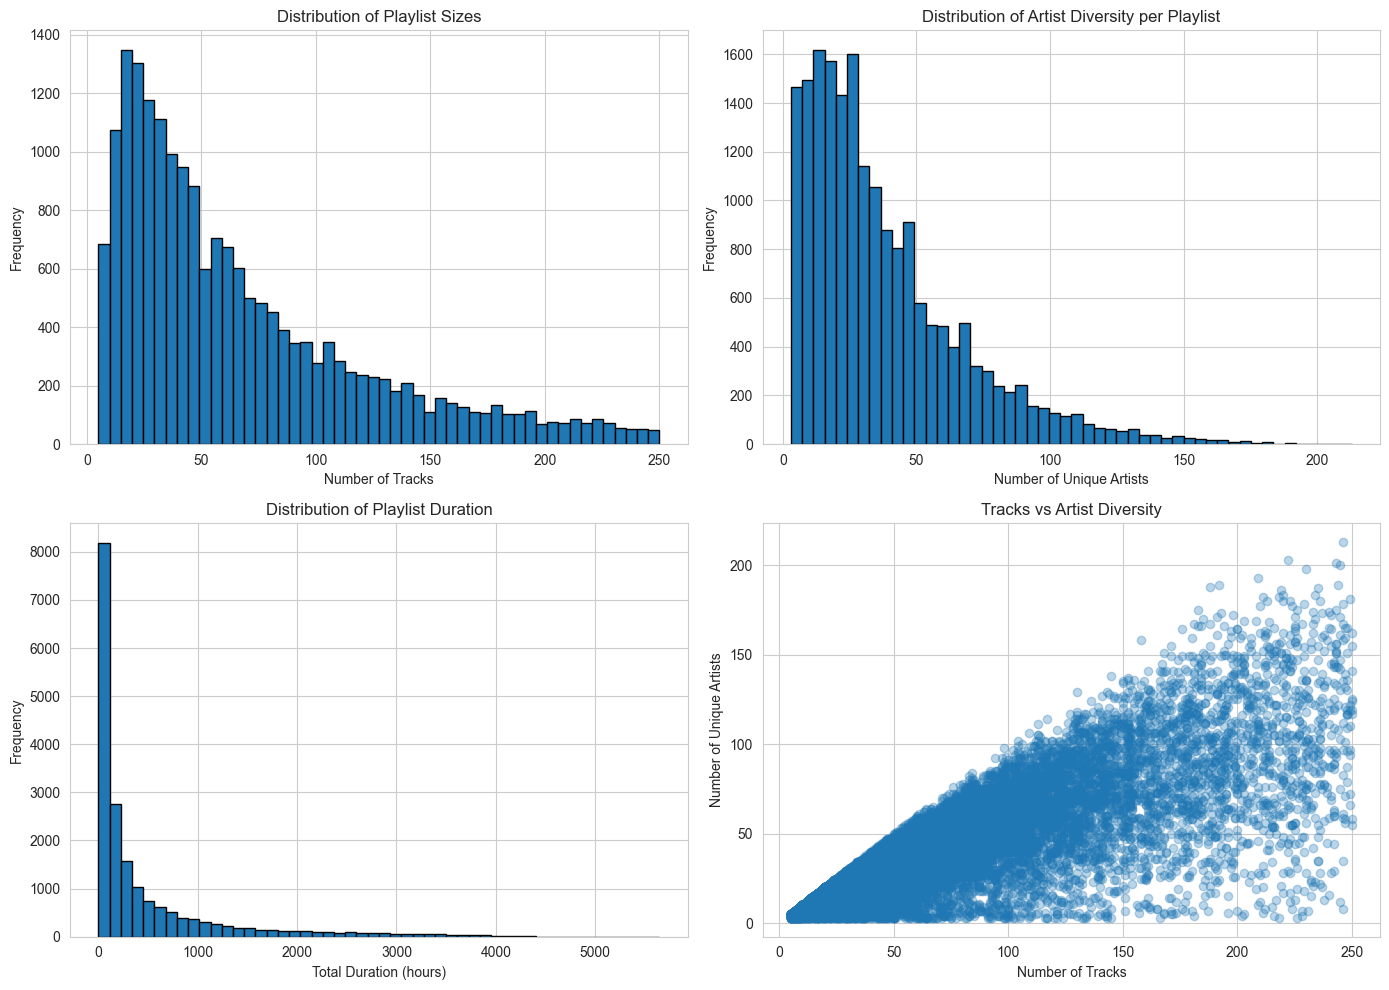

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(playlist_stats['num_tracks'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Number of Tracks')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Playlist Sizes')

axes[0, 1].hist(playlist_stats['num_unique_artists'], bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Number of Unique Artists')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Artist Diversity per Playlist')

axes[1, 0].hist(playlist_stats['total_duration_hours'], bins=50, edgecolor='black')
axes[1, 0].set_xlabel('Total Duration (hours)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Playlist Duration')

axes[1, 1].scatter(playlist_stats['num_tracks'], playlist_stats['num_unique_artists'], alpha=0.3)
axes[1, 1].set_xlabel('Number of Tracks')
axes[1, 1].set_ylabel('Number of Unique Artists')
axes[1, 1].set_title('Tracks vs Artist Diversity')

plt.tight_layout()
plt.show()


## Track Popularity and Coverage


In [15]:
track_popularity = tracks_df.groupby('track_uri').agg(
    num_playlists=('pid', 'nunique'),
    track_name=('track_name', 'first'),
    artist_name=('artist_name', 'first')
).sort_values('num_playlists', ascending=False)

print("Track popularity distribution:")
print(track_popularity['num_playlists'].describe())
print(f"\nTracks appearing in only 1 playlist: {(track_popularity['num_playlists'] == 1).sum():,} ({(track_popularity['num_playlists'] == 1).sum() / len(track_popularity) * 100:.1f}%)")
print(f"Tracks appearing in 2-5 playlists: {((track_popularity['num_playlists'] >= 2) & (track_popularity['num_playlists'] <= 5)).sum():,}")
print(f"Tracks appearing in 6+ playlists: {(track_popularity['num_playlists'] >= 6).sum():,}")


Track popularity distribution:
count    252999.000000
mean          4.965577
std          20.329565
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         865.000000
Name: num_playlists, dtype: float64

Tracks appearing in only 1 playlist: 156,793 (62.0%)
Tracks appearing in 2-5 playlists: 64,902
Tracks appearing in 6+ playlists: 31,304


In [16]:
print("Top 20 most popular tracks:")
track_popularity.head(20)


Top 20 most popular tracks:


,num_playlists,track_name,artist_name
track_uri,,,
spotify:track:7KXjTSCq5nL1LoYtL7XAwS,865,HUMBLE.,Kendrick Lamar
spotify:track:1xznGGDReH1oQq0xzbwXa3,839,One Dance,Drake
spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,796,Closer,The Chainsmokers
spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,795,Broccoli (feat. Lil Yachty),DRAM
spotify:track:3a1lNhkSLSkpJE4MSHpDu9,756,Congratulations,Post Malone
spotify:track:2EEeOnHehOozLq4aS0n6SL,707,iSpy (feat. Lil Yachty),KYLE
spotify:track:5hTpBe8h35rJ67eAWHQsJx,693,Caroline,Aminé
spotify:track:152lZdxL1OR0ZMW6KquMif,679,Location,Khalid
spotify:track:7GX5flRQZVHRAGd6B4TmDO,669,XO TOUR Llif3,Lil Uzi Vert


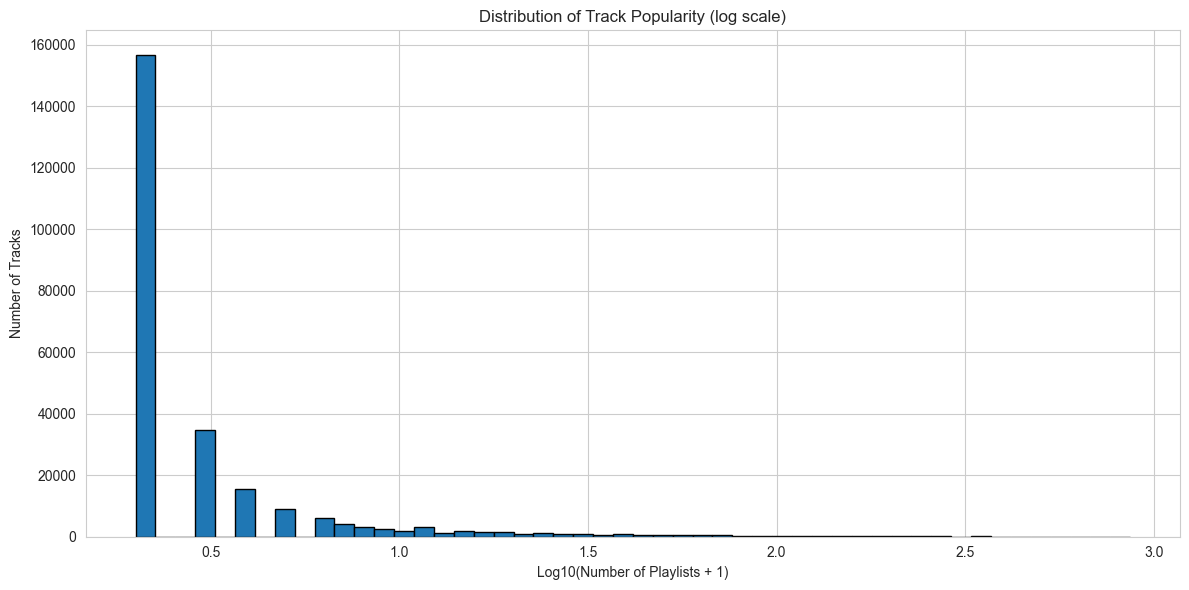

In [17]:
plt.figure(figsize=(12, 6))
plt.hist(np.log10(track_popularity['num_playlists'] + 1), bins=50, edgecolor='black')
plt.xlabel('Log10(Number of Playlists + 1)')
plt.ylabel('Number of Tracks')
plt.title('Distribution of Track Popularity (log scale)')
plt.tight_layout()
plt.show()


## Artist Analysis


In [18]:
artist_stats = tracks_df.groupby('artist_uri').agg(
    num_unique_tracks=('track_uri', 'nunique'),
    num_playlists=('pid', 'nunique'),
    artist_name=('artist_name', 'first')
).sort_values('num_playlists', ascending=False)

print("Artist statistics:")
print(artist_stats[['num_unique_tracks', 'num_playlists']].describe())
print(f"\nTop 20 artists by playlist appearances:")
artist_stats.head(20)


Artist statistics:
       num_unique_tracks  num_playlists
count       49124.000000   49124.000000
mean            5.150212      14.715862
std            12.489861      80.477635
min             1.000000       1.000000
25%             1.000000       1.000000
50%             1.000000       1.000000
75%             4.000000       4.000000
max           327.000000    3878.000000

Top 20 artists by playlist appearances:


,num_unique_tracks,num_playlists,artist_name
artist_uri,,,
spotify:artist:3TVXtAsR1Inumwj472S9r4,137,3878,Drake
spotify:artist:5pKCCKE2ajJHZ9KAiaK11H,153,2867,Rihanna
spotify:artist:5K4W6rqBFWDnAN6FQUkS6x,133,2729,Kanye West
spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ,85,2451,The Weeknd
spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,95,2328,Kendrick Lamar
spotify:artist:69GGBxA162lTqCwzJG5jLp,81,2158,The Chainsmokers
spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,106,2151,Ed Sheeran
spotify:artist:7CajNmpbOovFoOoasH2HaY,115,2070,Calvin Harris
spotify:artist:04gDigrS5kc9YWfZHwBETP,107,1906,Maroon 5


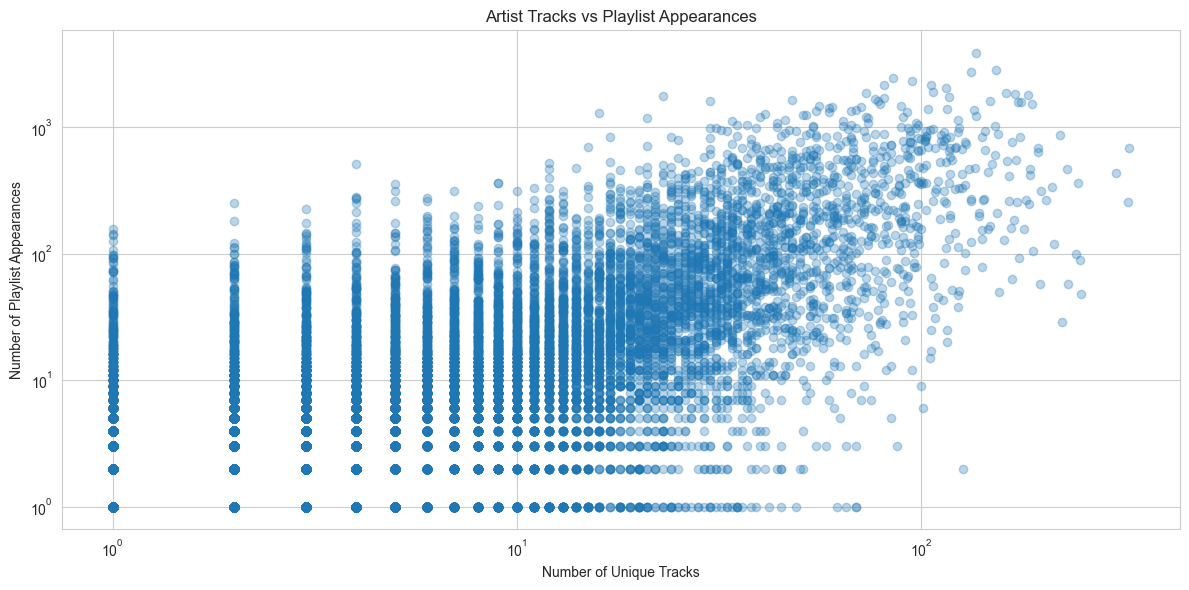

In [19]:
plt.figure(figsize=(12, 6))
plt.scatter(artist_stats['num_unique_tracks'], artist_stats['num_playlists'], alpha=0.3)
plt.xlabel('Number of Unique Tracks')
plt.ylabel('Number of Playlist Appearances')
plt.title('Artist Tracks vs Playlist Appearances')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()


## Collaborative Filtering Insights


In [20]:
interaction_matrix_shape = (tracks_df['pid'].nunique(), tracks_df['track_uri'].nunique())
total_possible_interactions = interaction_matrix_shape[0] * interaction_matrix_shape[1]
actual_interactions = len(tracks_df)
sparsity = 1 - (actual_interactions / total_possible_interactions)

print(f"Interaction Matrix Shape: {interaction_matrix_shape[0]:,} playlists x {interaction_matrix_shape[1]:,} tracks")
print(f"Total possible interactions: {total_possible_interactions:,}")
print(f"Actual interactions: {actual_interactions:,}")
print(f"Sparsity: {sparsity:.6f} ({sparsity * 100:.4f}%)")
print(f"Density: {(1 - sparsity) * 100:.6f}%")


Interaction Matrix Shape: 19,000 playlists x 252,999 tracks
Total possible interactions: 4,806,981,000
Actual interactions: 1,273,021
Sparsity: 0.999735 (99.9735%)
Density: 0.026483%


In [21]:
avg_tracks_per_playlist = tracks_df.groupby('pid').size().mean()
avg_playlists_per_track = tracks_df.groupby('track_uri').size().mean()

print(f"Average tracks per playlist: {avg_tracks_per_playlist:.2f}")
print(f"Average playlists per track: {avg_playlists_per_track:.2f}")


Average tracks per playlist: 67.00
Average playlists per track: 5.03


## Co-occurrence Analysis


In [22]:
sample_track = track_popularity.head(1).index[0]
sample_track_name = track_popularity.loc[sample_track, 'track_name']
sample_track_artist = track_popularity.loc[sample_track, 'artist_name']

playlists_with_track = tracks_df[tracks_df['track_uri'] == sample_track]['pid'].unique()
cooccurring_tracks = tracks_df[tracks_df['pid'].isin(playlists_with_track)]
cooccurrence_counts = cooccurring_tracks['track_name'].value_counts().head(20)

print(f"Sample track: '{sample_track_name}' by {sample_track_artist}")
print(f"Appears in {len(playlists_with_track)} playlists")
print(f"\nTop 20 tracks that appear with this track:")
cooccurrence_counts


Sample track: 'HUMBLE.' by Kendrick Lamar
Appears in 865 playlists

Top 20 tracks that appear with this track:


track_name
HUMBLE.                                    875
DNA.                                       412
XO TOUR Llif3                              397
Congratulations                            386
Mask Off                                   377
iSpy (feat. Lil Yachty)                    329
Bounce Back                                323
goosebumps                                 314
Bad and Boujee (feat. Lil Uzi Vert)        305
I'm the One                                284
T-Shirt                                    266
Slippery (feat. Gucci Mane)                265
Caroline                                   263
Tunnel Vision                              262
Broccoli (feat. Lil Yachty)                255
No Problem (feat. Lil Wayne & 2 Chainz)    245
Bank Account                               243
Drowning (feat. Kodak Black)               238
Unforgettable                              233
Magnolia                                   231
Name: count, dtype: int64

## Playlist Metadata Analysis


In [23]:
playlist_meta = tracks_df.groupby('pid').first()[['name', 'collaborative', 'modified_at', 'num_followers', 'num_edits']]

collab_raw = playlist_meta['collaborative'].astype(str).str.strip().str.lower()
playlist_meta['collaborative'] = collab_raw.isin({'true', '1', 'yes', 'y', 't'})

for c in ['num_followers', 'num_edits', 'modified_at']:
    if c in playlist_meta.columns:
        playlist_meta[c] = pd.to_numeric(playlist_meta[c], errors='coerce')

print("Playlist metadata sample:")
print(playlist_meta.head(10))
print("\nCollaborative value counts:")
print(playlist_meta['collaborative'].value_counts(dropna=False))


Playlist metadata sample:
                     name  collaborative  modified_at  num_followers  \
pid                                                                    
0              Throwbacks          False   1493424000              1   
1        Awesome Playlist          False   1506556800              1   
2                 korean           False   1505692800              1   
3                     mat          False   1501027200              1   
4                     90s          False   1401667200              2   
5                 Wedding          False   1430956800              1   
6    I Put A Spell On You          False   1477094400              1   
7                    2017          False   1509321600              1   
8                     BOP          False   1508976000              2   
9            old country           False   1501804800              1   

     num_edits  
pid             
0            6  
1            5  
2           18  
3            4  
4      

In [24]:
collab_count = int(playlist_meta['collaborative'].fillna(False).sum())
collab_pct = float(playlist_meta['collaborative'].fillna(False).mean() * 100)

print(f"Collaborative playlists: {collab_count} ({collab_pct:.1f}%)")
print(f"\nFollowers statistics:")
print(playlist_meta['num_followers'].describe())
print(f"\nEdits statistics:")
print(playlist_meta['num_edits'].describe())


Collaborative playlists: 436 (2.3%)

Followers statistics:
count    19000.000000
mean         2.551211
std         87.598167
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      11745.000000
Name: num_followers, dtype: float64

Edits statistics:
count    19000.000000
mean        17.842842
std         20.853155
min          2.000000
25%          5.000000
50%         10.000000
75%         23.000000
max        184.000000
Name: num_edits, dtype: float64


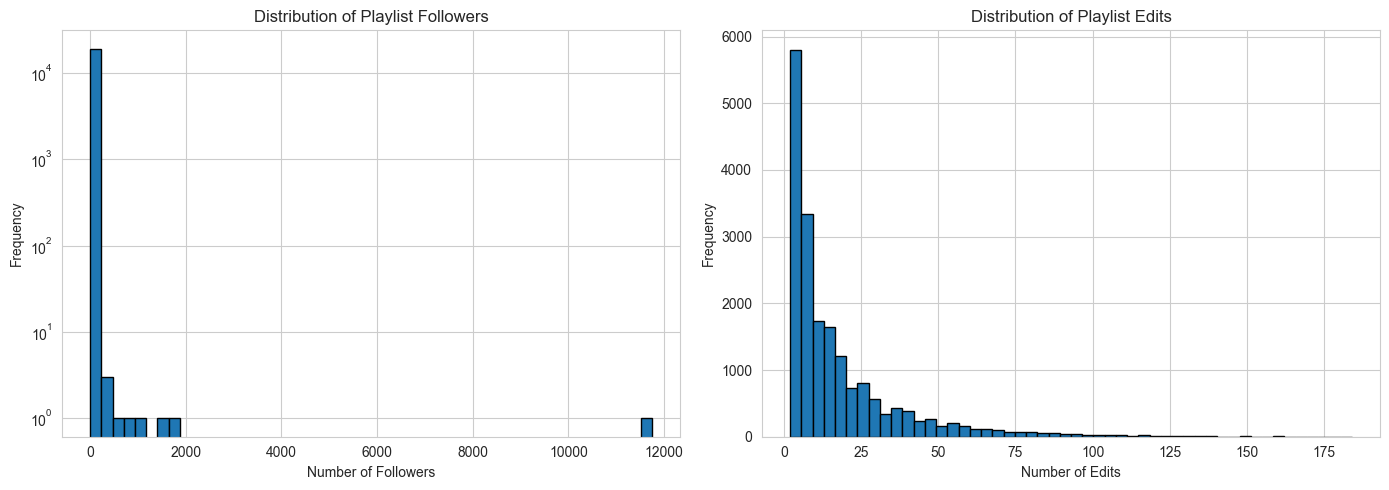

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(playlist_meta['num_followers'], bins=50, edgecolor='black')
axes[0].set_xlabel('Number of Followers')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Playlist Followers')
axes[0].set_yscale('log')

axes[1].hist(playlist_meta['num_edits'], bins=50, edgecolor='black')
axes[1].set_xlabel('Number of Edits')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Playlist Edits')

plt.tight_layout()
plt.show()


## Track Duration Analysis


Track duration statistics:
count    1.273021e+06
mean     4.328985e+02
std      2.532119e+02
min      9.261600e+00
25%      2.222406e+02
50%      3.926427e+02
75%      6.177020e+02
max      1.441197e+03
Name: duration_minutes, dtype: float64


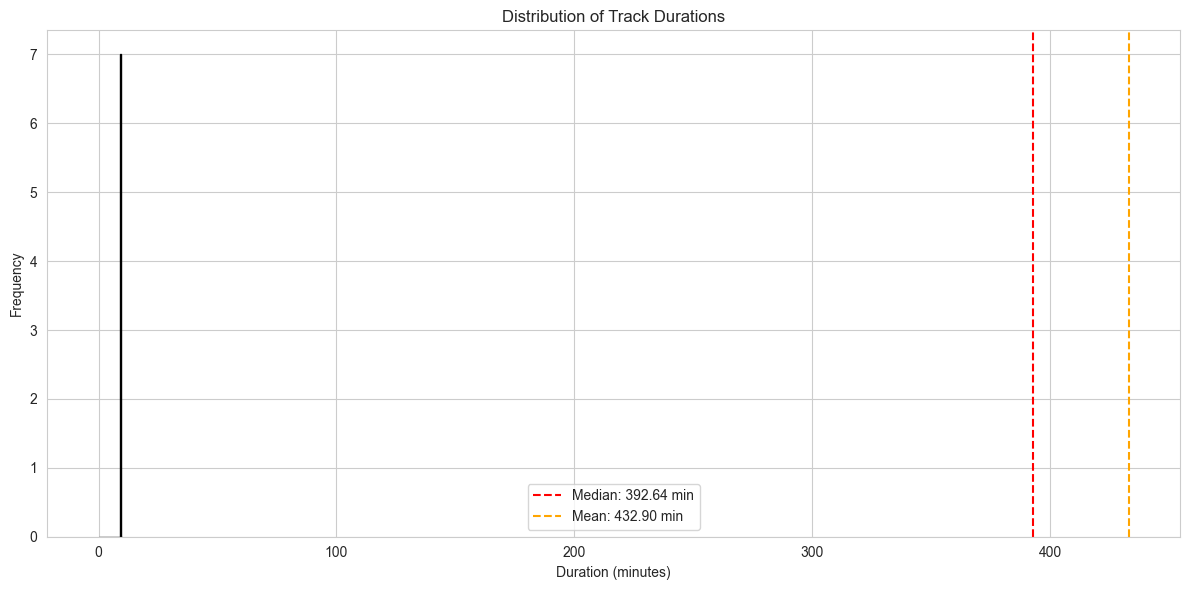

In [26]:
tracks_df['duration_minutes'] = tracks_df['duration_ms'] / (1000 * 60)

print("Track duration statistics:")
print(tracks_df['duration_minutes'].describe())

plt.figure(figsize=(12, 6))
plt.hist(tracks_df['duration_minutes'], bins=100, edgecolor='black', range=(0, 10))
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Track Durations')
plt.axvline(tracks_df['duration_minutes'].median(), color='red', linestyle='--', label=f"Median: {tracks_df['duration_minutes'].median():.2f} min")
plt.axvline(tracks_df['duration_minutes'].mean(), color='orange', linestyle='--', label=f"Mean: {tracks_df['duration_minutes'].mean():.2f} min")
plt.legend()
plt.tight_layout()
plt.show()


## Album Analysis


In [27]:
album_stats = tracks_df.groupby('album_uri').agg(
    album_name=('album_name', 'first'),
    artist_name=('artist_name', 'first'),
    num_tracks=('track_uri', 'nunique'),
    num_playlists=('pid', 'nunique')
).sort_values('num_playlists', ascending=False)

print("Top 20 albums by playlist appearances:")
album_stats.head(20)


Top 20 albums by playlist appearances:


,album_name,artist_name,num_tracks,num_playlists
album_uri,,,,
spotify:album:5s0rmjP8XOPhP6HhqOhuyC,Stoney,Post Malone,18,1588
spotify:album:3hARKC8cinq3mZLLAEaBh9,Views,Drake,4,1416
spotify:album:71QyofYesSsRMwFOTafnhB,Coloring Book,Chance The Rapper,14,1277
spotify:album:4eLPsYPBmXABThSJ821sqY,DAMN.,Kendrick Lamar,14,1251
spotify:album:28ZKQMoNBB0etKXZ97G2SN,Beauty Behind The Madness,The Weeknd,13,1216
spotify:album:6kf46HbnYCZzP6rjvQHYzg,American Teen,Khalid,15,1142
spotify:album:6NoBzYmh5gUusGPCfg0pct,x,Ed Sheeran,23,1118
spotify:album:1lXY618HWkwYKJWBRYR4MK,More Life,Drake,21,1088
spotify:album:7viNUmZZ8ztn2UB4XB3jIL,2014 Forest Hills Drive,J. Cole,13,1079


## Data Quality Checks


In [28]:
duplicates = tracks_df.duplicated(subset=['pid', 'track_uri']).sum()
print(f"Duplicate playlist-track pairs: {duplicates}")

print(f"\nTracks with missing artist_name: {tracks_df['artist_name'].isnull().sum()}")
print(f"Tracks with missing album_name: {tracks_df['album_name'].isnull().sum()}")
print(f"Tracks with missing duration: {tracks_df['duration_ms'].isnull().sum()}")

print(f"\nTracks with zero or negative duration: {(tracks_df['duration_ms'] <= 0).sum()}")
print(f"Tracks with extremely long duration (>30 min): {(tracks_df['duration_minutes'] > 30).sum()}")


Duplicate playlist-track pairs: 16735

Tracks with missing artist_name: 0
Tracks with missing album_name: 0
Tracks with missing duration: 0

Tracks with zero or negative duration: 0
Tracks with extremely long duration (>30 min): 1270276


## Recommendation System Considerations


In [29]:
print("Key insights for recommendation system design:\n")

print(f"1. Data Scale:")
print(f"   - {tracks_df['pid'].nunique():,} playlists (users)")
print(f"   - {tracks_df['track_uri'].nunique():,} unique tracks (items)")
print(f"   - {len(tracks_df):,} interactions")
print(f"   - Sparsity: {sparsity * 100:.4f}%")

print(f"\n2. Cold Start Problem:")
print(f"   - {(track_popularity['num_playlists'] == 1).sum():,} tracks appear in only 1 playlist")
print(f"   - {(track_popularity['num_playlists'] <= 5).sum():,} tracks appear in 5 or fewer playlists")

print(f"\n3. Popularity Bias:")
print(f"   - Top 1% of tracks ({len(track_popularity) // 100:,}) account for significant coverage")
print(f"   - Median track appears in {track_popularity['num_playlists'].median():.0f} playlists")
print(f"   - Mean track appears in {track_popularity['num_playlists'].mean():.2f} playlists")

print(f"\n4. User Engagement:")
print(f"   - Average playlist size: {avg_tracks_per_playlist:.2f} tracks")
print(f"   - Median playlist size: {playlist_stats['num_tracks'].median():.0f} tracks")

print(f"\n5. Content Diversity:")
print(f"   - {tracks_df['artist_uri'].nunique():,} unique artists")
print(f"   - {tracks_df['album_uri'].nunique():,} unique albums")
print(f"   - Average artists per playlist: {playlist_stats['num_unique_artists'].mean():.2f}")


Key insights for recommendation system design:

1. Data Scale:
   - 19,000 playlists (users)
   - 252,999 unique tracks (items)
   - 1,273,021 interactions
   - Sparsity: 99.9735%

2. Cold Start Problem:
   - 156,793 tracks appear in only 1 playlist
   - 221,695 tracks appear in 5 or fewer playlists

3. Popularity Bias:
   - Top 1% of tracks (2,529) account for significant coverage
   - Median track appears in 1 playlists
   - Mean track appears in 4.97 playlists

4. User Engagement:
   - Average playlist size: 67.00 tracks
   - Median playlist size: 49 tracks

5. Content Diversity:
   - 49,124 unique artists
   - 115,697 unique albums
   - Average artists per playlist: 38.05


## Position Analysis


Track position statistics:
count    1.273021e+06
mean     5.502880e+01
std      4.876908e+01
min      0.000000e+00
25%      1.700000e+01
50%      4.000000e+01
75%      8.000000e+01
max      2.490000e+02
Name: pos, dtype: float64


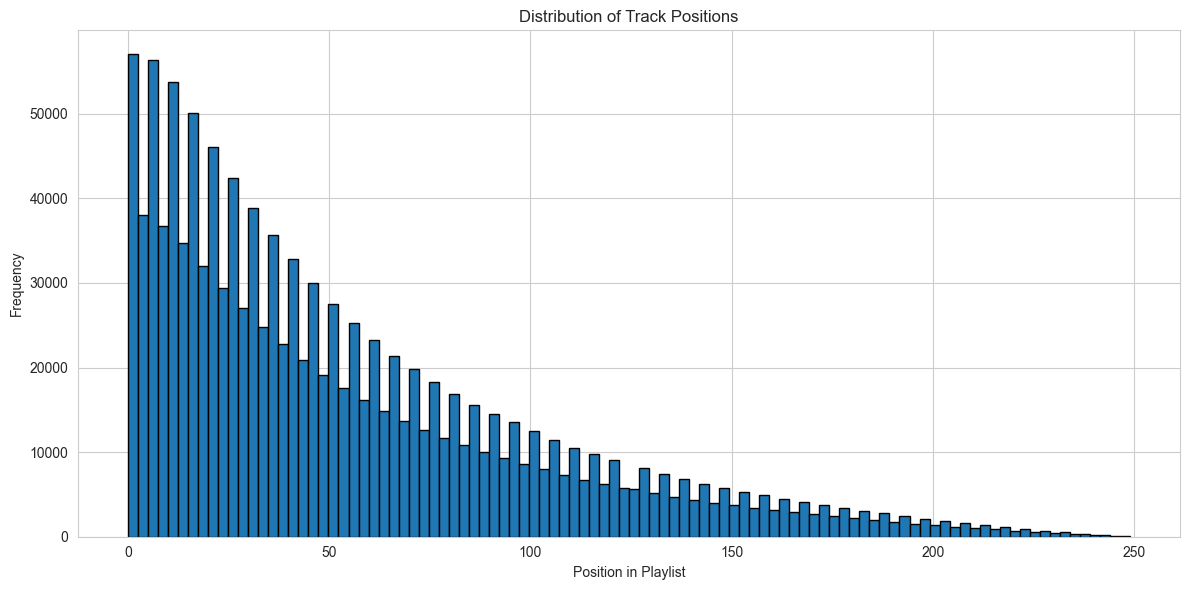

In [30]:
print("Track position statistics:")
print(tracks_df['pos'].describe())

plt.figure(figsize=(12, 6))
plt.hist(tracks_df['pos'], bins=100, edgecolor='black')
plt.xlabel('Position in Playlist')
plt.ylabel('Frequency')
plt.title('Distribution of Track Positions')
plt.tight_layout()
plt.show()


Average position of top 100 most popular tracks:
Mean: 49.39
Median: 47.64


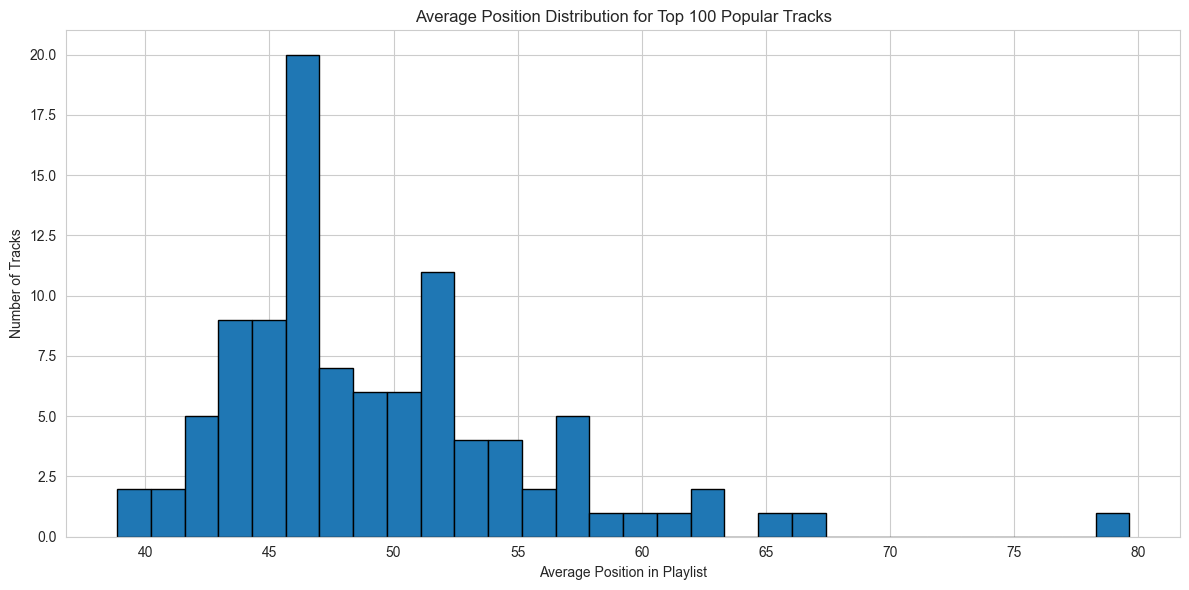

In [31]:
popular_tracks_positions = tracks_df[tracks_df['track_uri'].isin(track_popularity.head(100).index)]
avg_position_by_popularity = popular_tracks_positions.groupby('track_uri')['pos'].mean().sort_values()

print(f"Average position of top 100 most popular tracks:")
print(f"Mean: {avg_position_by_popularity.mean():.2f}")
print(f"Median: {avg_position_by_popularity.median():.2f}")

plt.figure(figsize=(12, 6))
plt.hist(avg_position_by_popularity, bins=30, edgecolor='black')
plt.xlabel('Average Position in Playlist')
plt.ylabel('Number of Tracks')
plt.title('Average Position Distribution for Top 100 Popular Tracks')
plt.tight_layout()
plt.show()


## Summary Statistics Table


In [32]:
summary_data = {
    'Metric': [
        'Total Playlists',
        'Total Unique Tracks',
        'Total Unique Artists',
        'Total Unique Albums',
        'Total Interactions',
        'Avg Tracks per Playlist',
        'Avg Playlists per Track',
        'Matrix Sparsity (%)',
        'Tracks in 1 Playlist Only',
        'Median Track Duration (min)',
        'Avg Artist Diversity per Playlist'
    ],
    'Value': [
        f"{tracks_df['pid'].nunique():,}",
        f"{tracks_df['track_uri'].nunique():,}",
        f"{tracks_df['artist_uri'].nunique():,}",
        f"{tracks_df['album_uri'].nunique():,}",
        f"{len(tracks_df):,}",
        f"{avg_tracks_per_playlist:.2f}",
        f"{avg_playlists_per_track:.2f}",
        f"{sparsity * 100:.4f}",
        f"{(track_popularity['num_playlists'] == 1).sum():,}",
        f"{tracks_df['duration_minutes'].median():.2f}",
        f"{playlist_stats['num_unique_artists'].mean():.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df


,Metric,Value
0,Total Playlists,"19,000"
1,Total Unique Tracks,"252,999"
2,Total Unique Artists,"49,124"
3,Total Unique Albums,"115,697"
4,Total Interactions,"1,273,021"
5,Avg Tracks per Playlist,67.00
6,Avg Playlists per Track,5.03
7,Matrix Sparsity (%),99.9735
8,Tracks in 1 Playlist Only,"156,793"
9,Median Track Duration (min),392.64
